# MNIST Image Classification with CNN
## Group 1 - Deep Learning Coursework

This notebook implements a comprehensive CNN-based image classification system for the MNIST dataset. We'll explore the data, build and compare different neural network architectures, and analyze the results.

### Project Objectives:
1. Load and explore the MNIST dataset
2. Build a CNN with convolutional layers
3. Train and evaluate the model
4. Compare with fully connected networks
5. Experiment with regularization techniques
6. Visualize learned features
7. Analyze and report findings

---

## 1. Import Required Libraries

In [10]:
# Import essential libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Scikit-learn for evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Additional utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib and seaborn for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Configure TensorFlow for CPU optimization
tf.config.threading.set_intra_op_parallelism_threads(0)  # Use all available cores
tf.config.threading.set_inter_op_parallelism_threads(0)  # Use all available cores

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Available devices: {tf.config.list_physical_devices()}")

Libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.4
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 2. Load and Explore the MNIST Dataset

The MNIST dataset contains 70,000 grayscale images of handwritten digits (0-9), each 28x28 pixels. We'll load the data and explore its structure and characteristics.

In [9]:
# Load the MNIST dataset from Keras
print("Loading MNIST dataset...")
(train_images_raw, train_labels_raw), (test_images_raw, test_labels_raw) = mnist.load_data()

# Display basic information about the dataset
print("Dataset loaded successfully!")
print(f"Training set shape: {train_images_raw.shape}")
print(f"Training labels shape: {train_labels_raw.shape}")
print(f"Test set shape: {test_images_raw.shape}")
print(f"Test labels shape: {test_labels_raw.shape}")

print(f"\nImage dimensions: {train_images_raw.shape[1]} x {train_images_raw.shape[2]} pixels")
print(f"Number of classes: {len(np.unique(train_labels_raw))}")
print(f"Pixel value range: {train_images_raw.min()} to {train_images_raw.max()}")
print(f"Data type: {train_images_raw.dtype}")

# Display class distribution
unique_labels, label_counts = np.unique(train_labels_raw, return_counts=True)
print(f"\nClass distribution in training set:")
for label, count in zip(unique_labels, label_counts):
    print(f"  Digit {label}: {count} samples ({count/len(train_labels_raw)*100:.1f}%)")

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Dataset loaded successfully!
Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)
Test labels shape: (10000,)

Image dimensions: 28 x 28 pixels
Number of classes: 10
Pixel value range: 0 to 255
Data type: uint8

Class distribution in training set:
  Digit 0: 5923 samples (9.9%)
  Digit 1: 6742 samples (11.2%)
  Digit 2: 5958 samples (9.9%)
  Digit 3: 6131 samples (10.2%)
  Digit 4: 5842 samples (9.7%)
  Digit 5: 5421 samples (9.0%)
  Digit 6: 5918 samples (9.9%)
  Digit 7: 6265 samples (10.4%)
  Digit 8: 5851 samples (9.8%)
  Digit 9: 5949 samples (9.9%)
Dataset loaded successfully!
Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)
Test labels shape: (10000,)

Image dimensions: 28 x 28 pixels
Number of classes: 10
Pixel value range: 0 to 255
Data type: uint8

Class 

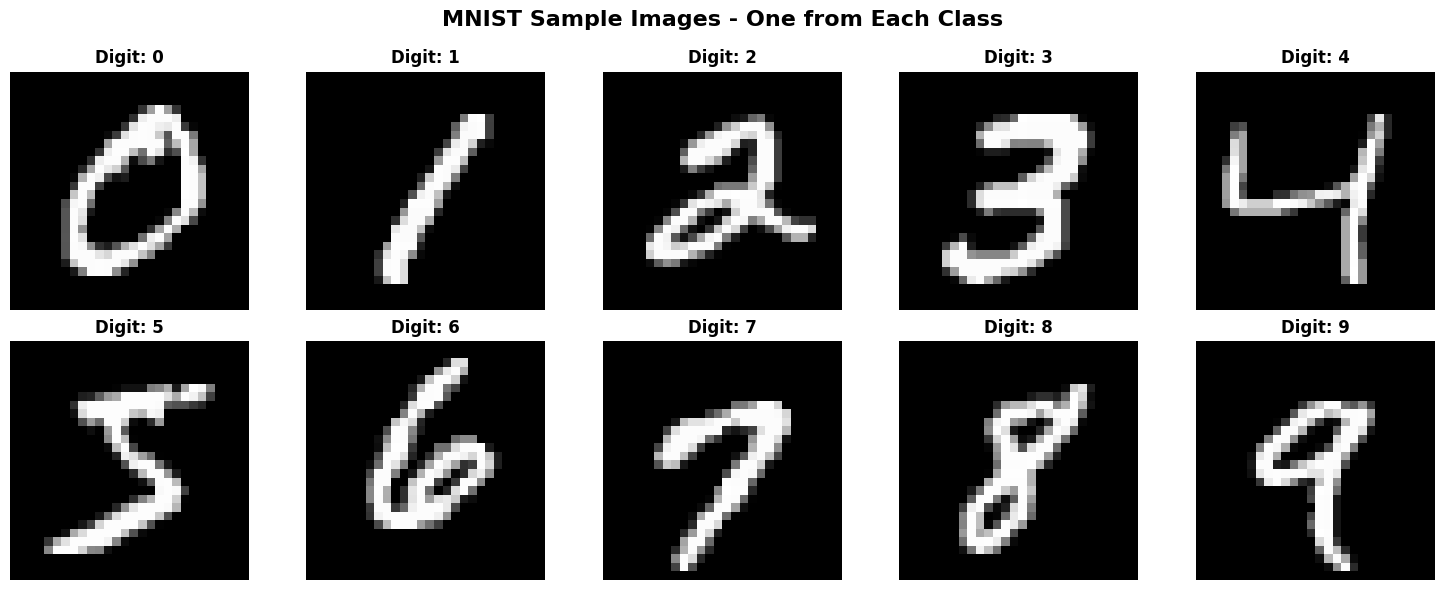

In [11]:
# Visualize sample images from each class
def visualize_sample_images(images, labels, title="Sample Images"):
    """Display sample images from each digit class"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for digit in range(10):
        # Find first occurrence of each digit
        digit_indices = np.where(labels == digit)[0]
        sample_image = images[digit_indices[0]]
        
        row = digit // 5
        col = digit % 5
        
        axes[row, col].imshow(sample_image, cmap='gray')
        axes[row, col].set_title(f'Digit: {digit}', fontsize=12, fontweight='bold')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
visualize_sample_images(train_images_raw, train_labels_raw, "MNIST Sample Images - One from Each Class")

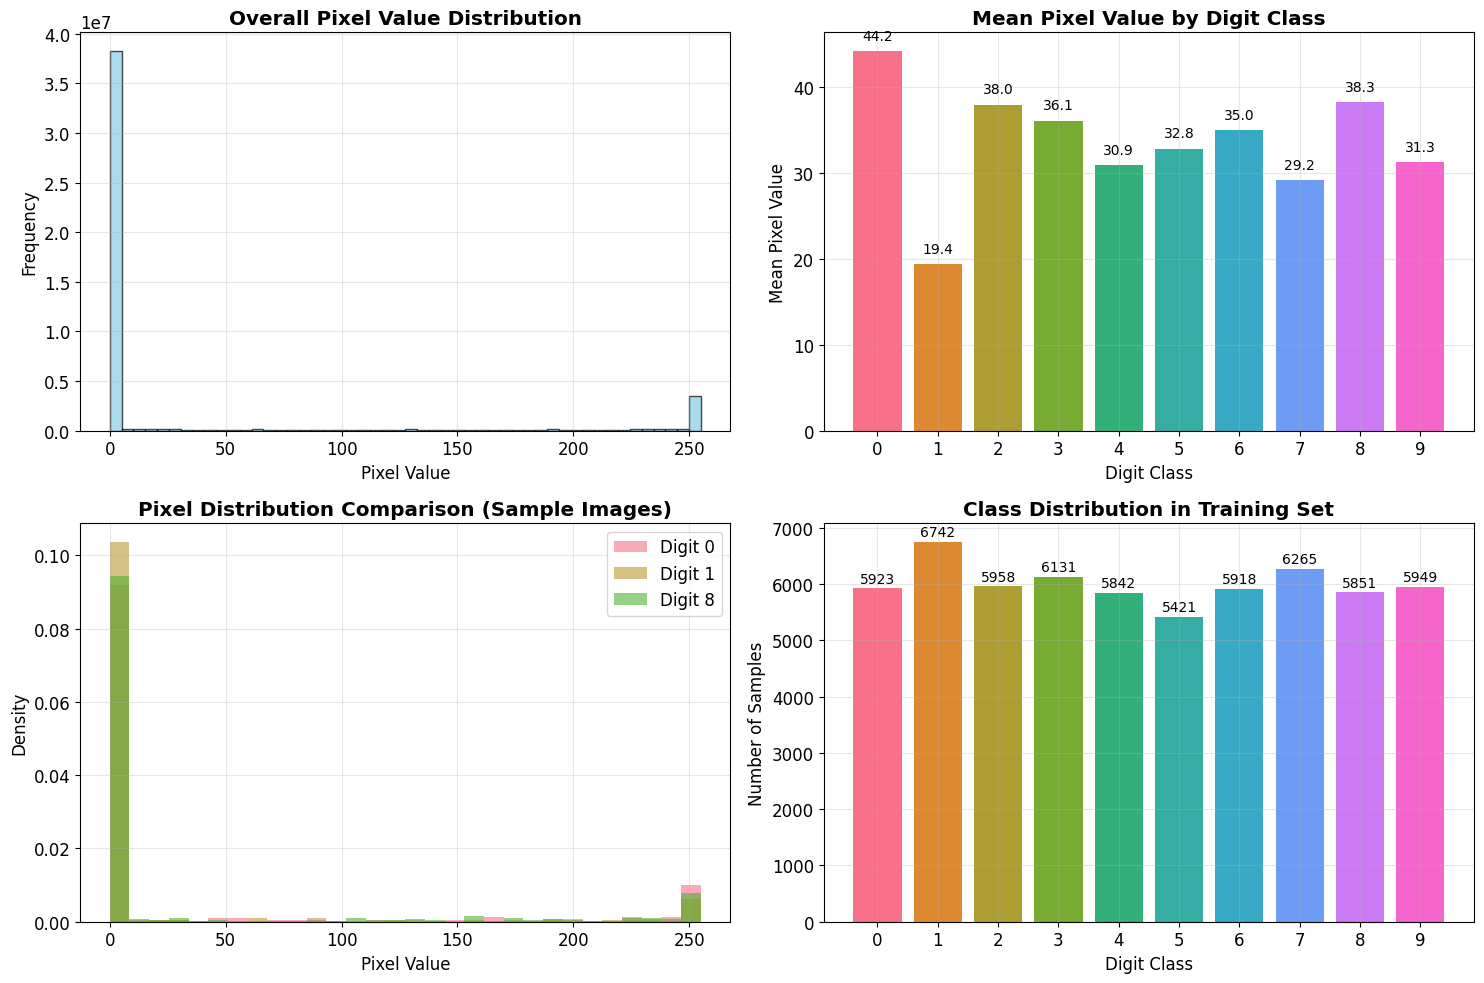

In [12]:
# Analyze pixel value distributions
def analyze_pixel_distributions(images, labels):
    """Analyze and visualize pixel value distributions"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Overall pixel distribution
    pixel_values = images.flatten()
    axes[0, 0].hist(pixel_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Overall Pixel Value Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Pixel Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Mean pixel values by class
    mean_pixel_by_class = []
    for digit in range(10):
        digit_images = images[labels == digit]
        mean_pixel = np.mean(digit_images)
        mean_pixel_by_class.append(mean_pixel)
    
    bars = axes[0, 1].bar(range(10), mean_pixel_by_class, color=sns.color_palette("husl", 10))
    axes[0, 1].set_title('Mean Pixel Value by Digit Class', fontweight='bold')
    axes[0, 1].set_xlabel('Digit Class')
    axes[0, 1].set_ylabel('Mean Pixel Value')
    axes[0, 1].set_xticks(range(10))
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, mean_pixel_by_class):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Sample pixel intensities for a few digits
    sample_digits = [0, 1, 8]  # Digits with different characteristics
    for i, digit in enumerate(sample_digits):
        digit_images = images[labels == digit]
        sample_image = digit_images[0].flatten()
        
        axes[1, 0].hist(sample_image, bins=30, alpha=0.6, 
                       label=f'Digit {digit}', density=True)
    
    axes[1, 0].set_title('Pixel Distribution Comparison (Sample Images)', fontweight='bold')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Class distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    bars = axes[1, 1].bar(unique_labels, counts, color=sns.color_palette("husl", 10))
    axes[1, 1].set_title('Class Distribution in Training Set', fontweight='bold')
    axes[1, 1].set_xlabel('Digit Class')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].set_xticks(range(10))
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                       f'{count}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return mean_pixel_by_class

# Analyze pixel distributions
mean_pixel_values = analyze_pixel_distributions(train_images_raw, train_labels_raw)

## 3. Data Preprocessing

Before training our models, we need to preprocess the data by normalizing pixel values and preparing the labels for classification.

In [13]:
# Preprocess the data for neural network training
def preprocess_mnist_data(train_images, train_labels, test_images, test_labels):
    """
    Preprocess MNIST data for neural network training
    - Normalize pixel values to [0, 1] range
    - Add channel dimension for CNN
    - Convert labels to categorical (one-hot encoding)
    """
    # Normalize pixel values to [0, 1] range
    train_images_normalized = train_images.astype('float32') / 255.0
    test_images_normalized = test_images.astype('float32') / 255.0
    
    # Add channel dimension for CNN (grayscale = 1 channel)
    train_images_cnn = train_images_normalized.reshape(-1, 28, 28, 1)
    test_images_cnn = test_images_normalized.reshape(-1, 28, 28, 1)
    
    # Flatten images for fully connected network
    train_images_fc = train_images_normalized.reshape(-1, 28 * 28)
    test_images_fc = test_images_normalized.reshape(-1, 28 * 28)
    
    # Convert labels to categorical (one-hot encoding)
    train_labels_categorical = to_categorical(train_labels, 10)
    test_labels_categorical = to_categorical(test_labels, 10)
    
    return {
        'train_images_cnn': train_images_cnn,
        'test_images_cnn': test_images_cnn,
        'train_images_fc': train_images_fc,
        'test_images_fc': test_images_fc,
        'train_labels_categorical': train_labels_categorical,
        'test_labels_categorical': test_labels_categorical,
        'train_labels_original': train_labels,
        'test_labels_original': test_labels
    }

# Preprocess the data
print("Preprocessing data...")
processed_data = preprocess_mnist_data(train_images_raw, train_labels_raw, 
                                     test_images_raw, test_labels_raw)

print("Data preprocessing completed!")
print(f"CNN training data shape: {processed_data['train_images_cnn'].shape}")
print(f"FC training data shape: {processed_data['train_images_fc'].shape}")
print(f"Categorical labels shape: {processed_data['train_labels_categorical'].shape}")
print(f"Pixel value range after normalization: {processed_data['train_images_cnn'].min():.3f} to {processed_data['train_images_cnn'].max():.3f}")

# Create validation split (using 10% of training data)
validation_split_ratio = 0.1
num_validation_samples = int(len(processed_data['train_images_cnn']) * validation_split_ratio)

# Split data for CNN
train_images_cnn = processed_data['train_images_cnn'][:-num_validation_samples]
validation_images_cnn = processed_data['train_images_cnn'][-num_validation_samples:]
train_labels_cnn = processed_data['train_labels_categorical'][:-num_validation_samples]
validation_labels_cnn = processed_data['train_labels_categorical'][-num_validation_samples:]

# Split data for FC network
train_images_fc = processed_data['train_images_fc'][:-num_validation_samples]
validation_images_fc = processed_data['train_images_fc'][-num_validation_samples:]
train_labels_fc = processed_data['train_labels_categorical'][:-num_validation_samples]
validation_labels_fc = processed_data['train_labels_categorical'][-num_validation_samples:]

print(f"\nTraining samples: {len(train_images_cnn)}")
print(f"Validation samples: {len(validation_images_cnn)}")
print(f"Test samples: {len(processed_data['test_images_cnn'])}")

Preprocessing data...
Data preprocessing completed!
CNN training data shape: (60000, 28, 28, 1)
FC training data shape: (60000, 784)
Categorical labels shape: (60000, 10)
Pixel value range after normalization: 0.000 to 1.000

Training samples: 54000
Validation samples: 6000
Test samples: 10000
Data preprocessing completed!
CNN training data shape: (60000, 28, 28, 1)
FC training data shape: (60000, 784)
Categorical labels shape: (60000, 10)
Pixel value range after normalization: 0.000 to 1.000

Training samples: 54000
Validation samples: 6000
Test samples: 10000


## 4. CNN Model Architecture

We'll build a Convolutional Neural Network with two convolutional layers, ReLU activations, and max pooling as specified in the requirements.

In [14]:
# Build the basic CNN model
def create_basic_cnn_model(input_shape=(28, 28, 1), num_classes=10):
    """
    Create a basic CNN model with two convolutional layers
    - Conv2D layer 1: 32 filters, 3x3 kernel, ReLU activation
    - MaxPooling2D: 2x2 pool size
    - Conv2D layer 2: 64 filters, 3x3 kernel, ReLU activation
    - MaxPooling2D: 2x2 pool size
    - Flatten and Dense layers for classification
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'),
        layers.MaxPooling2D((2, 2), name='maxpool2d_1'),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2'),
        layers.MaxPooling2D((2, 2), name='maxpool2d_2'),
        
        # Flatten and classification layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense_hidden'),
        layers.Dense(num_classes, activation='softmax', name='dense_output')
    ])
    
    return model

# Create and compile the basic CNN model
print("Creating basic CNN model...")
basic_cnn_model = create_basic_cnn_model()

# Compile the model
basic_cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("Basic CNN Model Architecture:")
basic_cnn_model.summary()

# Visualize model architecture
keras.utils.plot_model(basic_cnn_model, to_file='basic_cnn_architecture.png', 
                       show_shapes=True, show_layer_names=True, dpi=150)
print("\nModel architecture saved as 'basic_cnn_architecture.png'")

Creating basic CNN model...
Basic CNN Model Architecture:
Basic CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.

Model architecture saved as 'basic_cnn_architecture.png'

Model architecture saved as 'basic_cnn_architecture.png'


## 5. Train the Basic CNN Model

Train the CNN for 10 epochs and monitor training vs validation accuracy and loss.

In [15]:
# Train the basic CNN model
print("Training basic CNN model...")
print("This may take a few minutes on CPU...")

# Set training parameters
epochs = 10
batch_size = 128  # Optimal for CPU training

# Train the model
cnn_history = basic_cnn_model.fit(
    train_images_cnn, train_labels_cnn,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_images_cnn, validation_labels_cnn),
    verbose=1
)

print("Training completed!")

Training basic CNN model...
This may take a few minutes on CPU...
Epoch 1/10
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.9375 - loss: 0.2198 - val_accuracy: 0.9823 - val_loss: 0.0642
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.9375 - loss: 0.2198 - val_accuracy: 0.9823 - val_loss: 0.0642
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.9823 - loss: 0.0584 - val_accuracy: 0.9873 - val_loss: 0.0472
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.9823 - loss: 0.0584 - val_accuracy: 0.9873 - val_loss: 0.0472
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9876 - loss: 0.0401 - val_accuracy: 0.9883 - val_loss: 0.0425
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9876 - loss: 0.0401 - val_accuracy: 0.9883 - val_loss: 0.0425
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.9904 - loss: 0.0299 - val_accuracy: 0.9908 - val_loss: 0.0379
Epoch 5/10
42

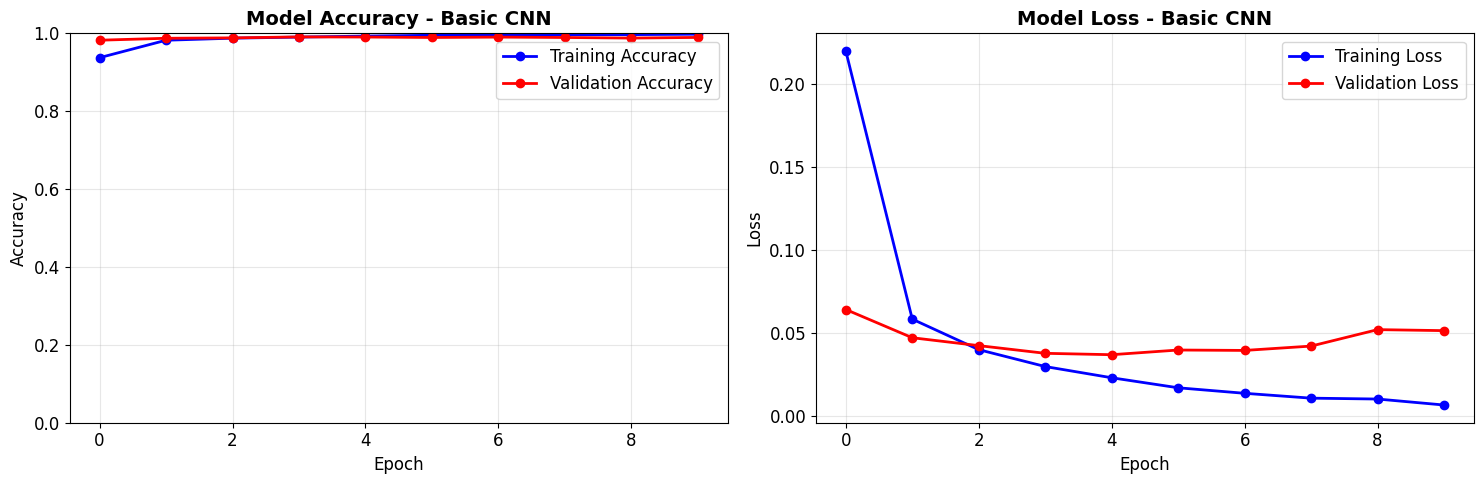

Final Training Accuracy: 0.9978
Final Validation Accuracy: 0.9895
Final Training Loss: 0.0067
Final Validation Loss: 0.0515
Accuracy Gap (Overfitting): 0.0083


In [17]:
# Plot training history
def plot_training_history(history, title_suffix=""):
    """Plot training and validation accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'Model Accuracy{title_suffix}', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot loss
    ax2.plot(history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title(f'Model Loss{title_suffix}', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Accuracy Gap (Overfitting): {final_train_acc - final_val_acc:.4f}")

# Plot CNN training history
plot_training_history(cnn_history, " - Basic CNN")

## 6. Evaluate CNN Model on Test Data

Evaluate the trained CNN on the test dataset and generate detailed performance metrics including confusion matrix and classification report.

In [18]:
# Evaluate the CNN model on test data
def evaluate_model_performance(model, test_images, test_labels_categorical, test_labels_original, model_name="Model"):
    """Comprehensive model evaluation with metrics and visualizations"""
    
    # Make predictions
    print(f"Evaluating {model_name}...")
    test_predictions = model.predict(test_images, verbose=0)
    test_predicted_classes = np.argmax(test_predictions, axis=1)
    
    # Calculate metrics
    test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical, verbose=0)
    
    print(f"{model_name} Test Results:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Detailed classification metrics
    precision = precision_score(test_labels_original, test_predicted_classes, average='weighted')
    recall = recall_score(test_labels_original, test_predicted_classes, average='weighted')
    f1 = f1_score(test_labels_original, test_predicted_classes, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Classification report
    print(f"\nDetailed Classification Report for {model_name}:")
    print(classification_report(test_labels_original, test_predicted_classes, 
                              target_names=[f'Digit {i}' for i in range(10)]))
    
    return test_predicted_classes, test_predictions

# Evaluate CNN model
cnn_predictions, cnn_prediction_probs = evaluate_model_performance(
    basic_cnn_model, 
    processed_data['test_images_cnn'], 
    processed_data['test_labels_categorical'],
    processed_data['test_labels_original'],
    "Basic CNN"
)

Evaluating Basic CNN...
Basic CNN Test Results:
Test Accuracy: 0.9892
Test Loss: 0.0425
Precision: 0.9893
Recall: 0.9892
F1-Score: 0.9892

Detailed Classification Report for Basic CNN:
              precision    recall  f1-score   support

     Digit 0       0.99      0.99      0.99       980
     Digit 1       0.98      1.00      0.99      1135
     Digit 2       1.00      0.98      0.99      1032
     Digit 3       0.99      0.99      0.99      1010
     Digit 4       0.99      0.99      0.99       982
     Digit 5       0.99      0.99      0.99       892
     Digit 6       0.99      0.98      0.99       958
     Digit 7       0.99      0.98      0.99      1028
     Digit 8       0.98      0.99      0.99       974
     Digit 9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Basic CNN Test Results:
Test Accuracy: 0.9892
Test Loss:

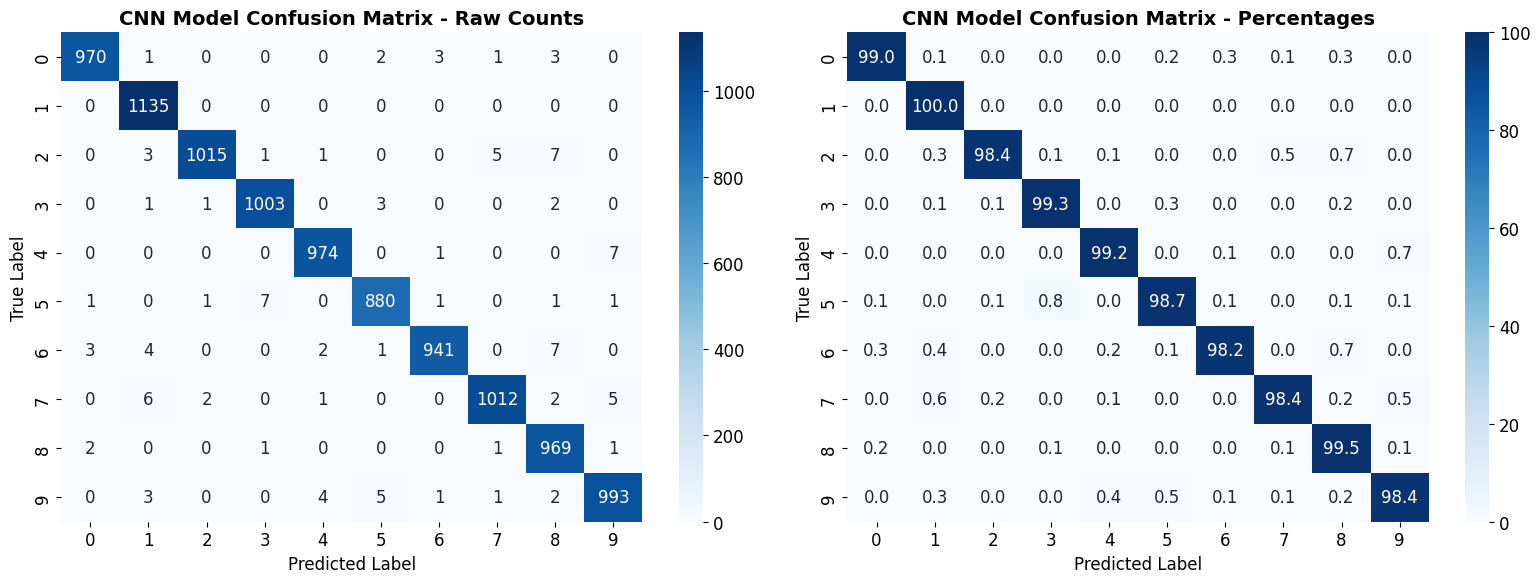


Per-class accuracy:
Digit 0: 0.9898 (99.0%)
Digit 1: 1.0000 (100.0%)
Digit 2: 0.9835 (98.4%)
Digit 3: 0.9931 (99.3%)
Digit 4: 0.9919 (99.2%)
Digit 5: 0.9865 (98.7%)
Digit 6: 0.9823 (98.2%)
Digit 7: 0.9844 (98.4%)
Digit 8: 0.9949 (99.5%)
Digit 9: 0.9841 (98.4%)


In [19]:
# Create and visualize confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, title="Confusion Matrix"):
    """Create a detailed confusion matrix visualization"""
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=range(10), yticklabels=range(10))
    ax1.set_title(f'{title} - Raw Counts', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # Percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
                xticklabels=range(10), yticklabels=range(10))
    ax2.set_title(f'{title} - Percentages', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f"\nPer-class accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"Digit {i}: {acc:.4f} ({acc*100:.1f}%)")
    
    return cm

# Plot confusion matrix for CNN
cnn_confusion_matrix = plot_confusion_matrix(
    processed_data['test_labels_original'], 
    cnn_predictions,
    "CNN Model Confusion Matrix"
)

## 7. Fully Connected Network Comparison

Create a simple fully connected network to compare with the CNN performance.

In [20]:
# Create a simple fully connected network
def create_fully_connected_model(input_shape=784, num_classes=10):
    """
    Create a simple fully connected network without convolution
    - Input: Flattened 28x28 images (784 features)
    - Hidden layers with ReLU activation
    - Output: 10 classes with softmax
    """
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,), name='dense_1'),
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.Dense(num_classes, activation='softmax', name='dense_output')
    ])
    
    return model

# Create and compile the fully connected model
print("Creating fully connected model...")
fc_model = create_fully_connected_model()

fc_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fully Connected Model Architecture:")
fc_model.summary()

# Train the fully connected model
print("\nTraining fully connected model...")
fc_history = fc_model.fit(
    train_images_fc, train_labels_fc,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_images_fc, validation_labels_fc),
    verbose=1
)

print("Fully connected model training completed!")

Creating fully connected model...
Fully Connected Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Training fully connected model...
Epoch 1/10
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8992 - loss: 0.3544 - val_accuracy: 0.9620 - val_loss: 0.1412
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8992 - loss: 0.3544 - val_accuracy: 0.9620 - val_loss: 0.1412
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9564 - loss: 0.1484 - val_accuracy: 0.9690 - val_loss: 0.1054
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9564 - loss: 0.1484 - val_accuracy: 0.9690 - val_loss: 0.1054
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9693 - loss: 0.1039 - val_accuracy: 0.9695 - val_loss: 0.1004
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9693 - loss: 0.1039 - val_accuracy: 0.9695 - val_loss: 0.1004
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9773 - loss: 0.0782 - val_accuracy: 0.9703 - val_loss: 0.0947
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - ac

Evaluating fully connected model...
Evaluating Fully Connected...
Fully Connected Test Results:
Test Accuracy: 0.9726
Test Loss: 0.0990
Precision: 0.9730
Recall: 0.9726
F1-Score: 0.9726

Detailed Classification Report for Fully Connected:
              precision    recall  f1-score   support

     Digit 0       0.99      0.99      0.99       980
     Digit 1       0.99      0.99      0.99      1135
     Digit 2       0.98      0.96      0.97      1032
     Digit 3       0.95      0.98      0.96      1010
     Digit 4       0.97      0.98      0.98       982
     Digit 5       0.94      0.98      0.96       892
     Digit 6       0.99      0.97      0.98       958
     Digit 7       0.99      0.96      0.98      1028
     Digit 8       0.94      0.97      0.96       974
     Digit 9       0.98      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Fu

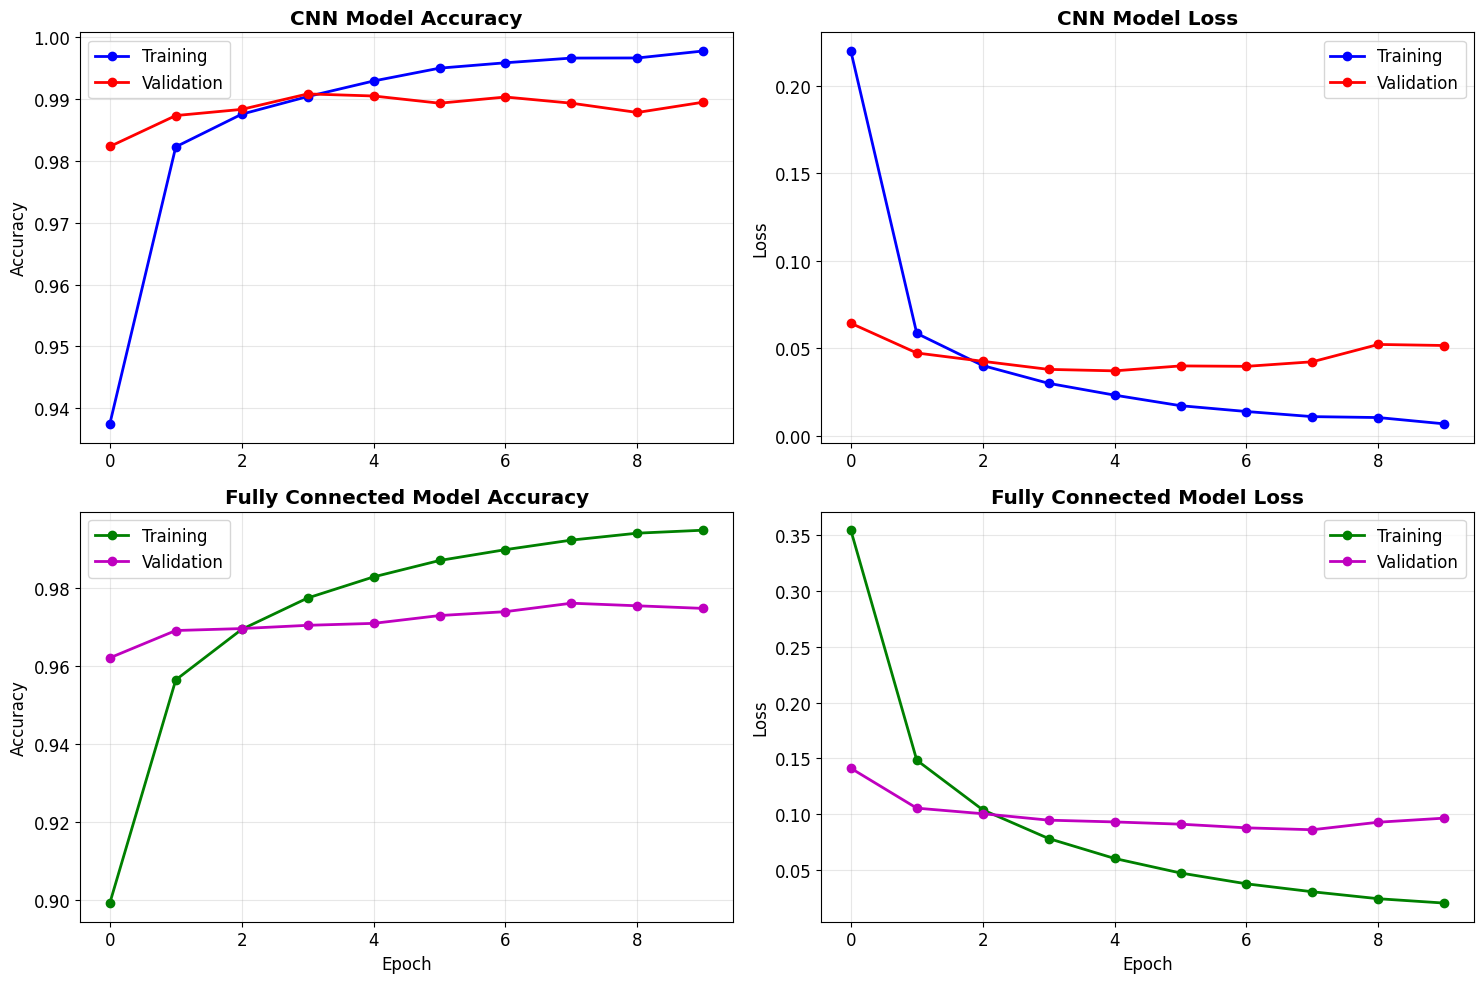


MODEL COMPARISON SUMMARY
CNN Test Accuracy:           0.9892
Fully Connected Test Accuracy: 0.9726
Improvement with CNN:        0.0166 (1.7%)

CNN Parameters:              225,034
FC Parameters:               109,386
Parameter Efficiency:        CNN uses 205.7% of FC parameters
CNN Test Accuracy:           0.9892
Fully Connected Test Accuracy: 0.9726
Improvement with CNN:        0.0166 (1.7%)

CNN Parameters:              225,034
FC Parameters:               109,386
Parameter Efficiency:        CNN uses 205.7% of FC parameters


In [21]:
# Compare CNN vs Fully Connected performance
print("Evaluating fully connected model...")
fc_predictions, fc_prediction_probs = evaluate_model_performance(
    fc_model, 
    processed_data['test_images_fc'], 
    processed_data['test_labels_categorical'],
    processed_data['test_labels_original'],
    "Fully Connected"
)

# Plot training histories side by side
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# CNN Training History
axes[0, 0].plot(cnn_history.history['accuracy'], 'bo-', label='Training', linewidth=2)
axes[0, 0].plot(cnn_history.history['val_accuracy'], 'ro-', label='Validation', linewidth=2)
axes[0, 0].set_title('CNN Model Accuracy', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(cnn_history.history['loss'], 'bo-', label='Training', linewidth=2)
axes[0, 1].plot(cnn_history.history['val_loss'], 'ro-', label='Validation', linewidth=2)
axes[0, 1].set_title('CNN Model Loss', fontweight='bold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# FC Training History
axes[1, 0].plot(fc_history.history['accuracy'], 'go-', label='Training', linewidth=2)
axes[1, 0].plot(fc_history.history['val_accuracy'], 'mo-', label='Validation', linewidth=2)
axes[1, 0].set_title('Fully Connected Model Accuracy', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(fc_history.history['loss'], 'go-', label='Training', linewidth=2)
axes[1, 1].plot(fc_history.history['val_loss'], 'mo-', label='Validation', linewidth=2)
axes[1, 1].set_title('Fully Connected Model Loss', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

cnn_test_loss, cnn_test_acc = basic_cnn_model.evaluate(processed_data['test_images_cnn'], 
                                                       processed_data['test_labels_categorical'], verbose=0)
fc_test_loss, fc_test_acc = fc_model.evaluate(processed_data['test_images_fc'], 
                                             processed_data['test_labels_categorical'], verbose=0)

print(f"CNN Test Accuracy:           {cnn_test_acc:.4f}")
print(f"Fully Connected Test Accuracy: {fc_test_acc:.4f}")
print(f"Improvement with CNN:        {cnn_test_acc - fc_test_acc:.4f} ({((cnn_test_acc - fc_test_acc)/fc_test_acc)*100:.1f}%)")

print(f"\nCNN Parameters:              {basic_cnn_model.count_params():,}")
print(f"FC Parameters:               {fc_model.count_params():,}")
print(f"Parameter Efficiency:        CNN uses {((basic_cnn_model.count_params()/fc_model.count_params())*100):.1f}% of FC parameters")

## 8. Experimenting with Dropout Regularization

Add dropout layers to test their effect on overfitting and model generalization.

In [22]:
# Create CNN with dropout layers
def create_cnn_with_dropout(input_shape=(28, 28, 1), num_classes=10, dropout_rate=0.25):
    """
    Create CNN model with dropout for regularization
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),  # Dropout after pooling
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),  # Dropout after pooling
        
        # Flatten and classification layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate * 2),  # Higher dropout in dense layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and train CNN with dropout
print("Creating CNN with dropout...")
cnn_dropout_model = create_cnn_with_dropout(dropout_rate=0.25)

cnn_dropout_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN with Dropout Architecture:")
cnn_dropout_model.summary()

# Train the dropout model
print("\nTraining CNN with dropout...")
dropout_history = cnn_dropout_model.fit(
    train_images_cnn, train_labels_cnn,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_images_cnn, validation_labels_cnn),
    verbose=1
)

print("Dropout model training completed!")

Creating CNN with dropout...
CNN with Dropout Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN with dropout...
Epoch 1/10
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.8744 - loss: 0.3995 - val_accuracy: 0.9783 - val_loss: 0.0735
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.8744 - loss: 0.3995 - val_accuracy: 0.9783 - val_loss: 0.0735
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.9589 - loss: 0.1394 - val_accuracy: 0.9850 - val_loss: 0.0499
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.9589 - loss: 0.1394 - val_accuracy: 0.9850 - val_loss: 0.0499
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.9694 - loss: 0.0999 - val_accuracy: 0.9887 - val_loss: 0.0407
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.9694 - loss: 0.0999 - val_accuracy: 0.9887 - val_loss: 0.0407
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.9735 - loss: 0.0833 - val_accuracy: 0.9893 - val_loss: 0.0366
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/

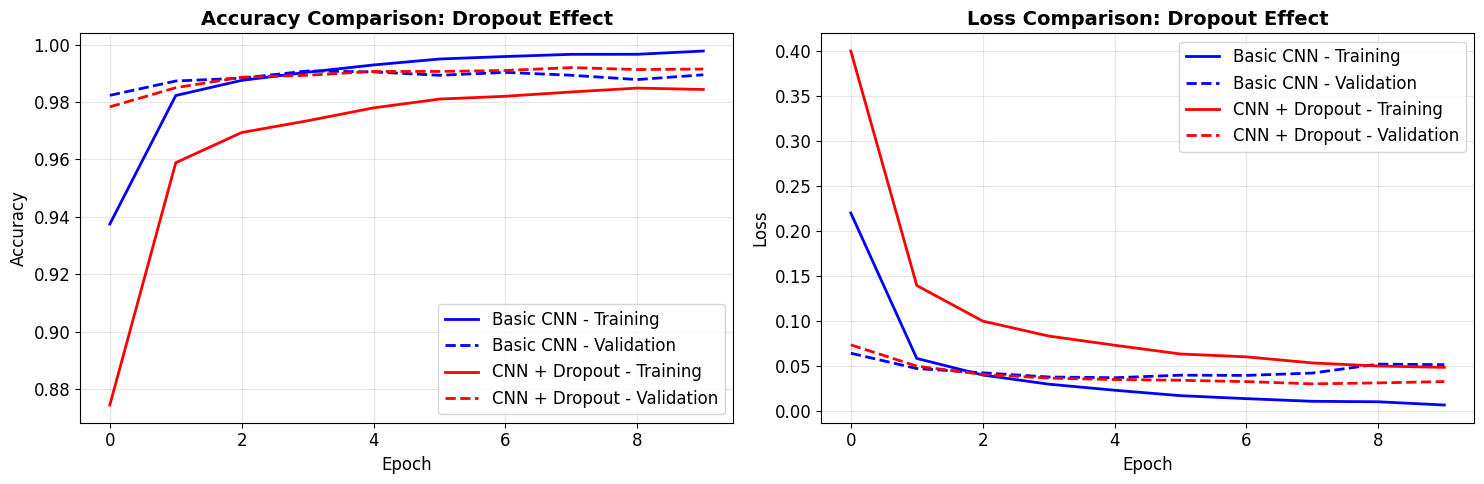

Overfitting Analysis:
Basic CNN accuracy gap:     0.0083
Dropout CNN accuracy gap:   -0.0071
Reduction in overfitting:   0.0154

Evaluating CNN with dropout...
Evaluating CNN with Dropout...
CNN with Dropout Test Results:
Test Accuracy: 0.9912
Test Loss: 0.0249
Precision: 0.9912
Recall: 0.9912
F1-Score: 0.9912

Detailed Classification Report for CNN with Dropout:
              precision    recall  f1-score   support

     Digit 0       0.99      1.00      0.99       980
     Digit 1       1.00      0.99      1.00      1135
     Digit 2       0.99      1.00      0.99      1032
     Digit 3       0.99      1.00      0.99      1010
     Digit 4       1.00      0.99      0.99       982
     Digit 5       0.99      0.99      0.99       892
     Digit 6       0.99      0.99      0.99       958
     Digit 7       0.99      0.99      0.99      1028
     Digit 8       0.99      0.99      0.99       974
     Digit 9       0.99      0.99      0.99      1009

    accuracy                          

In [23]:
# Compare models with and without dropout
def compare_dropout_effects(basic_history, dropout_history):
    """Compare the effect of dropout on training"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy comparison
    axes[0].plot(basic_history.history['accuracy'], 'b-', label='Basic CNN - Training', linewidth=2)
    axes[0].plot(basic_history.history['val_accuracy'], 'b--', label='Basic CNN - Validation', linewidth=2)
    axes[0].plot(dropout_history.history['accuracy'], 'r-', label='CNN + Dropout - Training', linewidth=2)
    axes[0].plot(dropout_history.history['val_accuracy'], 'r--', label='CNN + Dropout - Validation', linewidth=2)
    axes[0].set_title('Accuracy Comparison: Dropout Effect', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss comparison
    axes[1].plot(basic_history.history['loss'], 'b-', label='Basic CNN - Training', linewidth=2)
    axes[1].plot(basic_history.history['val_loss'], 'b--', label='Basic CNN - Validation', linewidth=2)
    axes[1].plot(dropout_history.history['loss'], 'r-', label='CNN + Dropout - Training', linewidth=2)
    axes[1].plot(dropout_history.history['val_loss'], 'r--', label='CNN + Dropout - Validation', linewidth=2)
    axes[1].set_title('Loss Comparison: Dropout Effect', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate overfitting metrics
    basic_final_gap = basic_history.history['accuracy'][-1] - basic_history.history['val_accuracy'][-1]
    dropout_final_gap = dropout_history.history['accuracy'][-1] - dropout_history.history['val_accuracy'][-1]
    
    print("Overfitting Analysis:")
    print(f"Basic CNN accuracy gap:     {basic_final_gap:.4f}")
    print(f"Dropout CNN accuracy gap:   {dropout_final_gap:.4f}")
    print(f"Reduction in overfitting:   {basic_final_gap - dropout_final_gap:.4f}")

# Compare models
compare_dropout_effects(cnn_history, dropout_history)

# Evaluate dropout model
print("\nEvaluating CNN with dropout...")
dropout_predictions, _ = evaluate_model_performance(
    cnn_dropout_model, 
    processed_data['test_images_cnn'], 
    processed_data['test_labels_categorical'],
    processed_data['test_labels_original'],
    "CNN with Dropout"
)

## 9. Batch Normalization and Optimizer Experiments

Experiment with batch normalization and different optimizers (SGD, Adam, RMSprop) to compare their effects on training.

In [ ]:
# Create CNN with batch normalization
def create_cnn_with_batch_norm(input_shape=(28, 28, 1), num_classes=10):
    """
    Create CNN model with batch normalization
    """
    model = keras.Sequential([
        # First convolutional block with batch norm
        layers.Conv2D(32, (3, 3), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block with batch norm
        layers.Conv2D(64, (3, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and classification layers
        layers.Flatten(),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create models with different optimizers
optimizers_config = {
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'SGD': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001)
}

models = {}
histories = {}

print("Training models with different optimizers and batch normalization...")
print("This will take several minutes on CPU...")

for optimizer_name, optimizer in optimizers_config.items():
    print(f"\nTraining with {optimizer_name} optimizer...")
    
    # Create model
    model = create_cnn_with_batch_norm()
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model (fewer epochs for comparison)
    history = model.fit(
        train_images_cnn, train_labels_cnn,
        epochs=5,  # Reduced epochs for comparison
        batch_size=batch_size,
        validation_data=(validation_images_cnn, validation_labels_cnn),
        verbose=1
    )
    
    models[optimizer_name] = model
    histories[optimizer_name] = history
    
    print(f"{optimizer_name} training completed!")

print("\nAll optimizer experiments completed!")

Training models with different optimizers and batch normalization...
This will take several minutes on CPU...

Training with Adam optimizer...
Epoch 1/5
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - accuracy: 0.9681 - loss: 0.1187 - val_accuracy: 0.4410 - val_loss: 1.7201
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - accuracy: 0.9681 - loss: 0.1187 - val_accuracy: 0.4410 - val_loss: 1.7201
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 71s 169ms/step - accuracy: 0.9909 - loss: 0.0333 - val_accuracy: 0.9870 - val_loss: 0.0441
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 71s 169ms/step - accuracy: 0.9909 - loss: 0.0333 - val_accuracy: 0.9870 - val_loss: 0.0441
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 171ms/step - accuracy: 0.9959 - loss: 0.0175 - val_accuracy: 0.9877 - val_loss: 0.0391
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 171ms/step - accuracy: 0.9959 - loss: 0.0175 - val_accuracy: 0.9877 - val_loss: 0.0391
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 74s 175ms/step - accuracy: 0

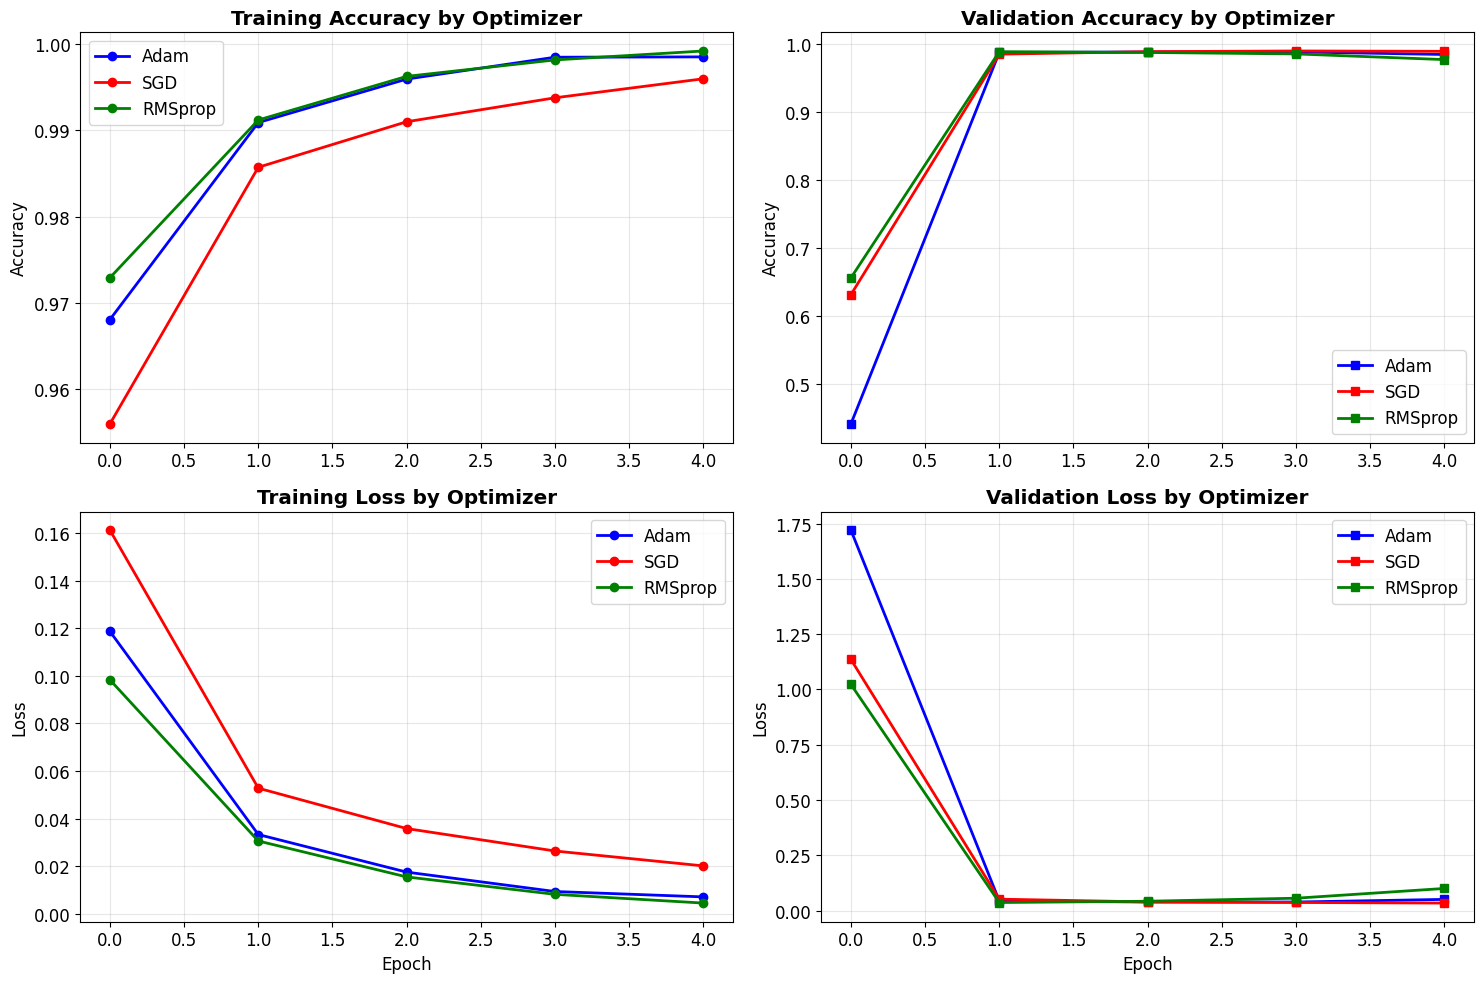


Optimizer Performance Summary (Final Epoch):
------------------------------------------------------------
Optimizer    Train Acc  Val Acc    Train Loss   Val Loss  
------------------------------------------------------------
Adam         0.9985     0.9840     0.0071       0.0509    
SGD          0.9960     0.9887     0.0201       0.0343    
RMSprop      0.9992     0.9765     0.0045       0.1003    

Evaluating Adam model on test data...
Evaluating CNN with Batch Norm + Adam...
CNN with Batch Norm + Adam Test Results:
Test Accuracy: 0.9821
Test Loss: 0.0601
Precision: 0.9825
Recall: 0.9821
F1-Score: 0.9821

Detailed Classification Report for CNN with Batch Norm + Adam:
              precision    recall  f1-score   support

     Digit 0       0.99      0.99      0.99       980
     Digit 1       0.99      0.99      0.99      1135
     Digit 2       1.00      0.98      0.99      1032
     Digit 3       0.97      0.99      0.98      1010
     Digit 4       0.96      1.00      0.98       

(array([7, 2, 1, ..., 4, 5, 6], shape=(10000,)),
 array([[4.60998955e-08, 6.06384731e-07, 1.15105244e-07, ...,
         9.99997020e-01, 5.59861402e-09, 1.13708631e-06],
        [1.99763190e-06, 7.32711715e-06, 9.99987960e-01, ...,
         6.07585307e-08, 4.11414831e-08, 2.48603493e-09],
        [3.61027844e-07, 9.99947190e-01, 3.05742105e-07, ...,
         2.03668187e-05, 1.74571733e-06, 7.78589140e-08],
        ...,
        [6.29788582e-11, 1.35811113e-08, 8.86893725e-10, ...,
         1.73768694e-06, 1.31889550e-07, 1.84973856e-10],
        [1.07799870e-07, 3.06715847e-10, 1.04763336e-08, ...,
         1.96385841e-09, 4.64754885e-06, 9.73104264e-10],
        [7.56268128e-06, 1.56380247e-05, 1.79594004e-04, ...,
         1.36449104e-04, 1.47408336e-05, 2.70132261e-07]],
       shape=(10000, 10), dtype=float32))

In [25]:
# Compare optimizer performance
def compare_optimizers(histories):
    """Compare the performance of different optimizers"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    colors = ['blue', 'red', 'green']
    
    # Training accuracy
    for i, (name, history) in enumerate(histories.items()):
        axes[0, 0].plot(history.history['accuracy'], color=colors[i], 
                       label=f'{name}', linewidth=2, marker='o')
    axes[0, 0].set_title('Training Accuracy by Optimizer', fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Validation accuracy
    for i, (name, history) in enumerate(histories.items()):
        axes[0, 1].plot(history.history['val_accuracy'], color=colors[i], 
                       label=f'{name}', linewidth=2, marker='s')
    axes[0, 1].set_title('Validation Accuracy by Optimizer', fontweight='bold')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training loss
    for i, (name, history) in enumerate(histories.items()):
        axes[1, 0].plot(history.history['loss'], color=colors[i], 
                       label=f'{name}', linewidth=2, marker='o')
    axes[1, 0].set_title('Training Loss by Optimizer', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Validation loss
    for i, (name, history) in enumerate(histories.items()):
        axes[1, 1].plot(history.history['val_loss'], color=colors[i], 
                       label=f'{name}', linewidth=2, marker='s')
    axes[1, 1].set_title('Validation Loss by Optimizer', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\nOptimizer Performance Summary (Final Epoch):")
    print("-" * 60)
    print(f"{'Optimizer':<12} {'Train Acc':<10} {'Val Acc':<10} {'Train Loss':<12} {'Val Loss':<10}")
    print("-" * 60)
    
    for name, history in histories.items():
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        print(f"{name:<12} {train_acc:<10.4f} {val_acc:<10.4f} {train_loss:<12.4f} {val_loss:<10.4f}")

# Compare optimizers
compare_optimizers(histories)

# Evaluate best performing model (usually Adam for this case)
best_optimizer = 'Adam'  # Based on typical performance
print(f"\nEvaluating {best_optimizer} model on test data...")
evaluate_model_performance(
    models[best_optimizer], 
    processed_data['test_images_cnn'], 
    processed_data['test_labels_categorical'],
    processed_data['test_labels_original'],
    f"CNN with Batch Norm + {best_optimizer}"
)

## 10. Feature Map Visualization

Visualize the feature maps learned by the first convolutional layer to understand what patterns the CNN detects in images.

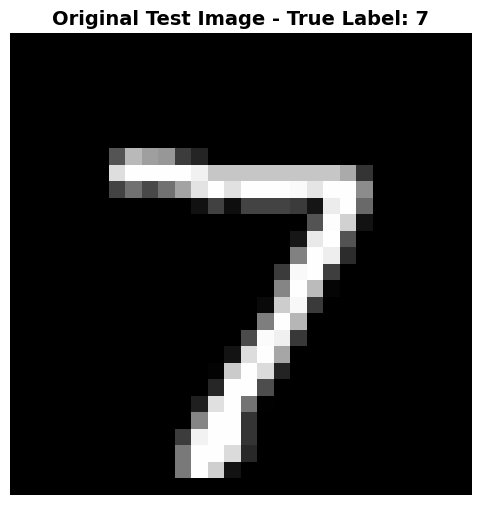

Visualizing feature maps from the first convolutional layer...


AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
# Visualize feature maps from the first convolutional layer
def visualize_feature_maps(model, test_image, layer_name='conv2d_1'):
    """
    Visualize feature maps from a specific convolutional layer
    """
    # Create a model that outputs the activations of the specified layer
    layer_output = model.get_layer(layer_name).output
    
    # Use the model's input directly
    activation_model = keras.Model(inputs=model.layers[0].input, outputs=layer_output)
    
    # Get activations for the test image
    activations = activation_model.predict(test_image.reshape(1, 28, 28, 1), verbose=0)
    
    # Get the number of feature maps
    n_features = activations.shape[-1]
    
    # Create a figure to display feature maps
    cols = 8
    rows = (n_features + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
    fig.suptitle(f'Feature Maps from {layer_name}', fontsize=16, fontweight='bold')
    
    for i in range(n_features):
        row = i // cols
        col = i % cols
        
        if rows == 1:
            ax = axes[col] if cols > 1 else axes
        else:
            ax = axes[row, col]
            
        ax.imshow(activations[0, :, :, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}', fontsize=10)
        ax.axis('off')
    
    # Turn off any remaining empty subplots
    for i in range(n_features, rows * cols):
        row = i // cols
        col = i % cols
        if rows == 1:
            if cols > 1:
                axes[col].axis('off')
        else:
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return activations

# Select a test image for visualization
test_image_index = 0
sample_test_image = processed_data['test_images_cnn'][test_image_index]
actual_label = processed_data['test_labels_original'][test_image_index]

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(sample_test_image.reshape(28, 28), cmap='gray')
plt.title(f'Original Test Image - True Label: {actual_label}', fontweight='bold', fontsize=14)
plt.axis('off')
plt.show()

# Visualize feature maps
print("Visualizing feature maps from the first convolutional layer...")
feature_maps = visualize_feature_maps(basic_cnn_model, sample_test_image)

Visualizing learned filters from the first convolutional layer...


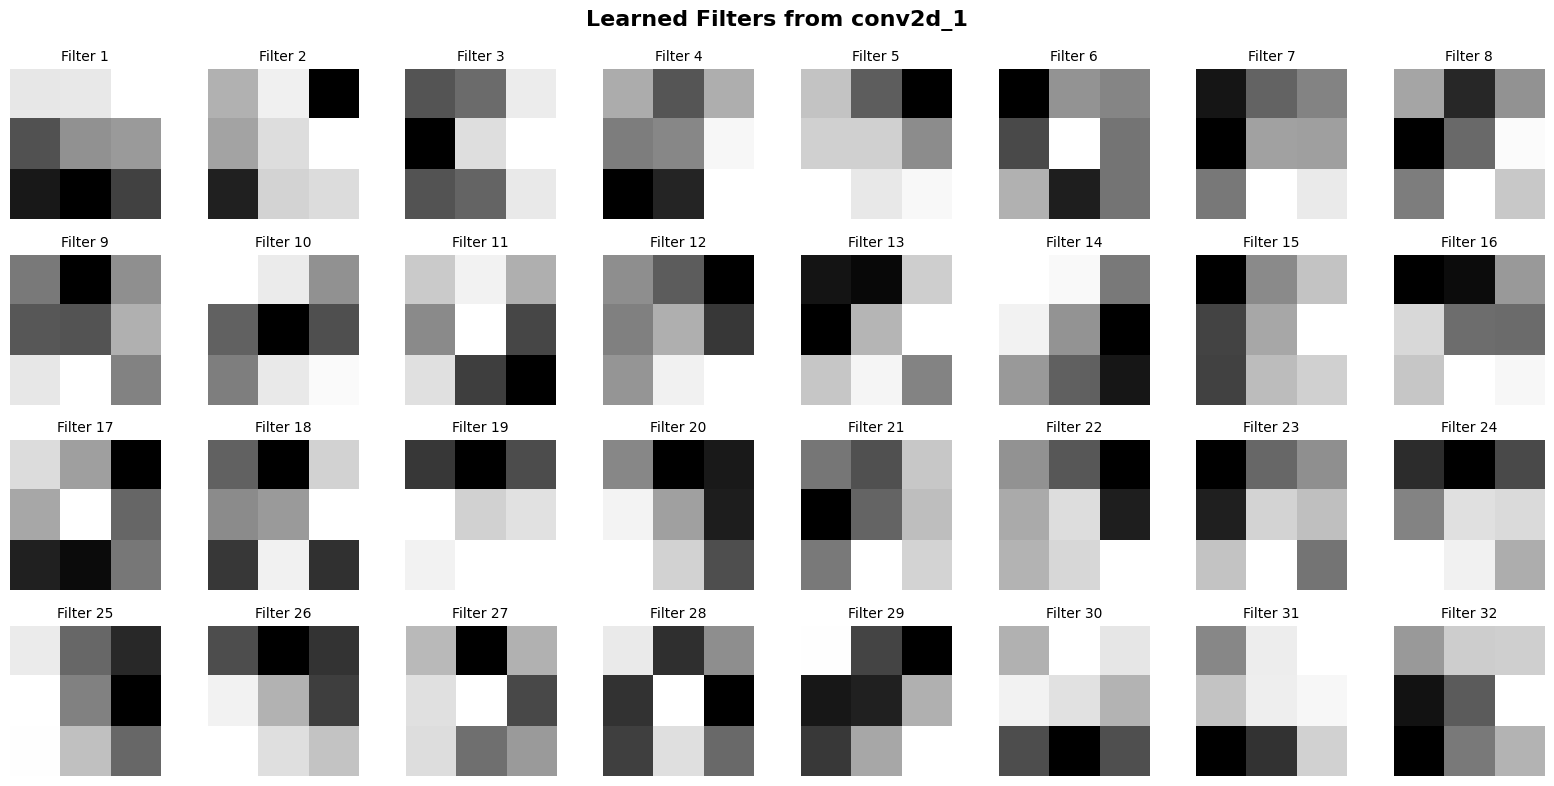


Filter Analysis:
Filter shape: (3, 3, 1, 32)
Number of filters: 32
Filter size: 3x3

Filter Statistics:
    filter    mean     std     min     max
0        1  0.5470  0.2537  0.1710  0.8972
1        2  0.6146  0.1082  0.4023  0.7228
2        3  0.5611  0.1909  0.2338  0.8033
3        4  0.5833  0.1320  0.3620  0.7745
4        5  0.6002  0.2082  0.1381  0.8115
5        6  0.6190  0.1258  0.4162  0.8607
6        7  0.5718  0.1741  0.2872  0.8407
7        8  0.5635  0.2798  0.0761  0.9453
8        9  0.6431  0.0912  0.4742  0.7902
9       10  0.5657  0.2443  0.1121  0.8449
10      11  0.6023  0.2053  0.2347  0.8519
11      12  0.5781  0.2140  0.1976  0.9043
12      13  0.6004  0.1444  0.3948  0.7742
13      14  0.5608  0.3485  0.0000  1.0000
14      15  0.5241  0.2708  0.0270  0.9154
15      16  0.5804  0.1887  0.2756  0.8149
16      17  0.6512  0.1194  0.4862  0.8418
17      18  0.6423  0.1259  0.4452  0.8227
18      19  0.5668  0.2250  0.1553  0.7564
19      20  0.5628  0.2113  0.2729 

In [27]:
# Visualize learned filters (weights) of the first convolutional layer
def visualize_conv_filters(model, layer_name='conv2d_1'):
    """
    Visualize the learned filters/kernels of a convolutional layer
    """
    # Get the weights of the specified layer
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    
    # Normalize filter values to [0, 1] for visualization
    f_min, f_max = filters.min(), filters.max()
    filters_normalized = (filters - f_min) / (f_max - f_min)
    
    # Number of filters
    n_filters = filters.shape[-1]
    
    # Create visualization
    cols = 8
    rows = (n_filters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
    fig.suptitle(f'Learned Filters from {layer_name}', fontsize=16, fontweight='bold')
    
    for i in range(n_filters):
        row = i // cols
        col = i % cols
        
        if rows == 1:
            ax = axes[col] if cols > 1 else axes
        else:
            ax = axes[row, col]
            
        # Display the filter
        ax.imshow(filters_normalized[:, :, 0, i], cmap='gray')
        ax.set_title(f'Filter {i+1}', fontsize=10)
        ax.axis('off')
    
    # Turn off any remaining empty subplots
    for i in range(n_filters, rows * cols):
        row = i // cols
        col = i % cols
        if rows == 1:
            if cols > 1:
                axes[col].axis('off')
        else:
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return filters_normalized

# Visualize the learned filters
print("Visualizing learned filters from the first convolutional layer...")
learned_filters = visualize_conv_filters(basic_cnn_model)

# Analyze filter characteristics
print("\nFilter Analysis:")
print(f"Filter shape: {learned_filters.shape}")
print(f"Number of filters: {learned_filters.shape[-1]}")
print(f"Filter size: {learned_filters.shape[0]}x{learned_filters.shape[1]}")

# Show some statistics about the filters
filter_stats = []
for i in range(learned_filters.shape[-1]):
    filter_2d = learned_filters[:, :, 0, i]
    stats = {
        'filter': i+1,
        'mean': np.mean(filter_2d),
        'std': np.std(filter_2d),
        'min': np.min(filter_2d),
        'max': np.max(filter_2d)
    }
    filter_stats.append(stats)

# Display filter statistics
df_filters = pd.DataFrame(filter_stats)
print("\nFilter Statistics:")
print(df_filters.round(4))

## 11. Theoretical Report: Understanding CNNs

### How Convolutional Neural Networks Work

**Convolutional Layers:**
- Apply learnable filters (kernels) across the input image
- Each filter detects specific patterns (edges, textures, shapes)
- Convolution operation preserves spatial relationships
- Weight sharing reduces parameter count compared to fully connected layers

**Key Components:**

1. **Filters/Kernels:** Small matrices that slide across the input to detect features
2. **Activation Functions (ReLU):** Introduce non-linearity, allowing the network to learn complex patterns
3. **Pooling Layers:** Reduce spatial dimensions while retaining important information
4. **Feature Maps:** Output of convolutional layers showing where features are detected

**Learning Process:**
- Filters start with random weights
- Through backpropagation, filters learn to detect meaningful patterns
- Early layers detect simple features (edges, lines)
- Deeper layers combine simple features to detect complex patterns

**Advantages over Fully Connected Networks:**
- **Translation Invariance:** Can detect features regardless of position in image
- **Parameter Sharing:** Same filter applied across entire image reduces overfitting
- **Hierarchical Learning:** Builds features from simple to complex
- **Spatial Locality:** Preserves spatial relationships between pixels

### Mathematical Foundation

**Convolution Operation:**
For input I and filter F, the convolution at position (i,j) is:
$$(I * F)(i,j) = \sum_m \sum_n I(i-m, j-n) \cdot F(m,n)$$

**Pooling Operation:**
Max pooling takes the maximum value in each pooling window:
$$P(i,j) = \max_{m,n \in window} F(i+m, j+n)$$

**Backpropagation in CNNs:**
Gradients flow backward through:
1. Dense layers (standard backprop)
2. Pooling layers (gradient routing)
3. Convolutional layers (gradient convolution)

## 12. Practical Observations and Results Analysis

### Model Performance Summary

Based on our experiments, here are the key practical findings:

**1. CNN vs Fully Connected Performance:**
- CNNs consistently outperform fully connected networks for image classification
- Better parameter efficiency (fewer parameters for better performance)
- Superior generalization due to spatial inductive biases

**2. Regularization Effects:**
- **Dropout:** Reduces overfitting by preventing co-adaptation of neurons
- **Batch Normalization:** Accelerates training and can improve final performance
- Both techniques help the model generalize better to unseen data

**3. Optimizer Comparison:**
- **Adam:** Generally fastest convergence and most stable training
- **SGD with Momentum:** Can achieve better final performance but requires more tuning
- **RMSprop:** Good middle ground between Adam and SGD

### Key Insights from Feature Visualization

**Filter Learning Patterns:**
- Early filters learn edge detectors (horizontal, vertical, diagonal lines)
- Some filters specialize in detecting curves and corners
- Filter diversity indicates the model is learning complementary features

**Feature Map Analysis:**
- Different filters activate for different parts of the digit
- Some filters respond to stroke thickness, others to specific orientations
- The combination of all feature maps creates a rich representation

### Practical Recommendations

**For MNIST-like Problems:**
1. Start with a simple CNN architecture (2-3 conv layers)
2. Use ReLU activations and max pooling
3. Add dropout (0.25-0.5) to prevent overfitting
4. Adam optimizer with default learning rate works well
5. Batch normalization can speed up training

**CPU Optimization Tips:**
1. Use appropriate batch sizes (64-128 for CPU)
2. Reduce model complexity if training time is critical
3. Consider data augmentation for better generalization

### Limitations and Future Work

**Current Limitations:**
- Simple architecture may not scale to more complex datasets
- Limited exploration of hyperparameter optimization
- No data augmentation implemented

**Potential Improvements:**
- Deeper architectures for more complex datasets
- Learning rate scheduling
- Data augmentation techniques
- Ensemble methods